In [1]:
!pip install lightautoml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.0/399.0 kB 5.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.1/216.1 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.5/309.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 66.8 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 29.2 MB/s eta 0:00:00:00:010

In [2]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
if torch.cuda.is_available():
    print("Current CUDA device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA available: True
CUDA device count: 1
Current CUDA device: 0
Device name: Tesla P100-PCIE-16GB


In [3]:
# Standard python libraries
import os

# Essential DS libraries
import optuna
import requests
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
from copy import deepcopy as copy
import torch.nn as nn
from collections import OrderedDict
from lightautoml.dataset.roles import DatetimeRole

# LightAutoML presets, task and report generation
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

In [35]:
N_THREADS = 4
N_FOLDS = 5
RANDOM_STATE = 42
TEST_SIZE = 0.35
TIMEOUT = 3 * 60 * 60
TARGET_NAME = 'BINARY_CLAIM'

np.random.seed(RANDOM_STATE)
torch.set_num_threads(N_THREADS)

In [27]:
import pandas as pd
df1 = pd.read_csv('/kaggle/input/vehicle-insurance-data/motor_data11-14lats.csv')
df2 = pd.read_csv('/kaggle/input/vehicle-insurance-data/motor_data14-2018.csv')
data = pd.concat([df1, df2])
#Modeling target
data['CLAIM_PAID'] = data['CLAIM_PAID'].fillna(0)
data['BINARY_CLAIM'] = data['CLAIM_PAID'].astype(bool).astype(int)
data['INSR_BEGIN'] = pd.to_datetime(data['INSR_BEGIN'], format='%d-%b-%y')
data['INSR_END'] = pd.to_datetime(data['INSR_END'], format='%d-%b-%y')

In [36]:
train_data, test_data = train_test_split(
    data,
    test_size=TEST_SIZE,
    stratify=data[TARGET_NAME],
    random_state=RANDOM_STATE
)

task = Task('binary')
roles = {
    'target': TARGET_NAME,
    'drop': ['INSURED_VALUE', 'OBJECT_ID', 'CLAIM_PAID', 'PREMIUM'],
    'category': ['TYPE_VEHICLE', 'USAGE', 'PROD_YEAR', 'SEATS_NUM', 'MAKE', 'EFFECTIVE_YR', 'SEX', 'INSR_TYPE'],
    'numeric': ['CARRYING_CAPACITY', 'CCM_TON'],
    DatetimeRole(seasonality=["y", "m", "wd"]): ["INSR_BEGIN", "INSR_END"],
    
}

In [37]:
automl = TabularAutoML(
    task = task,
    timeout = TIMEOUT,
    cpu_limit = N_THREADS,
    gpu_ids='0',
    general_params={  
        "use_algos": [["lgb", "lgb_tuned", "linear_l2", "fttransformer", "node", "dense", "denselight"]]
    },   # ['nn', 'mlp', 'dense', 'denselight', 'resnet', 'snn', 'node', 'autoint', 'fttransformer'] or custom torch model
    nn_params = {"n_epochs": 10, "bs": 512, "num_workers": 0, "path_to_save": None, "freeze_defaults": True},
    nn_pipeline_params = {"use_qnt": True, "use_te": False},
    reader_params = {'n_jobs': N_THREADS, 'cv': N_FOLDS, 'random_state': RANDOM_STATE}
)

In [38]:
from lightautoml.report import ReportDeco 
report_automl = ReportDeco(  
    output_path="/kaggle/working/report_boost_nn",           # Папка для сохранения отчетов  
    report_file_name="opensource_claims_LAMA_BOOST_NN.html" # Имя HTML файла  
)(automl)  

In [40]:
%%time
oof_pred = report_automl.fit_predict(train_data, roles = roles, verbose = 2)

[21:26:37] Stdout logging level is INFO2.
[21:26:37] Task: binary

[21:26:37] Start automl preset with listed constraints:
[21:26:37] - time: 10800.00 seconds
[21:26:37] - CPU: 4 cores
[21:26:37] - memory: 16 GB

[21:26:37] Train data shape: (521323, 17)

[21:26:51] Layer 1 train process start. Time left 10786.04 secs
[21:27:09] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[21:27:09] ===== Start working with fold 0 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:16] ===== Start working with fold 1 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:23] ===== Start working with fold 2 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:30] ===== Start working with fold 3 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:38] ===== Start working with fold 4 for Lvl_0_Pipe_0_Mod_0_LinearL2 =====
[21:27:46] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7314656060872824
[21:27:46] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[21:27:46] Time left 10731.68 secs

[21:27:54] Selector_LightG

Optimization Progress:   1%|          | 1/101 [00:17<28:42, 17.23s/it, best_trial=0, best_value=0.753]

[21:29:55] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM completed
[21:29:55] The set of hyperparameters {'feature_fraction': 0.6872700594236812, 'num_leaves': 244, 'bagging_fraction': 0.8659969709057025, 'min_sum_hessian_in_leaf': 0.24810409748678125, 'reg_alpha': 2.5361081166471375e-07, 'reg_lambda': 2.5348407664333426e-07}
 achieve 0.7530 auc
[21:29:55] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM ...
[21:29:55] ===== Start working with fold 0 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====


[21:30:12] ===== Start working with fold 1 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[21:30:28] ===== Start working with fold 2 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[21:30:47] ===== Start working with fold 3 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[21:31:03] ===== Start working with fold 4 for Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM =====
[21:31:14] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM finished. score = 0.756828171522709
[21:31:14] Lvl_0_Pipe_1_Mod_1_Tuned_LightGBM fitting and predicting completed
[21:31:14] Time left 10523.34 secs

[21:31:15] Start fitting Lvl_0_Pipe_2_Mod_0_TorchNN_fttransformer_0 ...
[21:31:15] ===== Start working with fold 0 for Lvl_0_Pipe_2_Mod_0_TorchNN_fttransformer_0 =====
[21:34:42] ===== Start working with fold 1 for Lvl_0_Pipe_2_Mod_0_TorchNN_fttransformer_0 =====
[21:38:12] ===== Start working with fold 2 for Lvl_0_Pipe_2_Mod_0_TorchNN_fttransformer_0 =====
[21:41:42] ===== Start working with fold 3 for Lvl_0_Pipe_2_Mod_0_TorchNN_fttransformer_0

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


CPU times: user 1h 33min 55s, sys: 14.8 s, total: 1h 34min 10s
Wall time: 45min 42s


In [41]:
from sklearn.metrics import roc_auc_score
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
test_predictions = report_automl.predict(test_data)
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7621928086285391


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


HOLDOUT score: 0.7660648345646929


In [13]:
from sklearn.metrics import roc_auc_score
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
test_predictions = report_automl.model.predict(test_data)
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7659316789456753
HOLDOUT score: 0.7668045586309884


In [24]:
from sklearn.metrics import roc_auc_score
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
test_predictions = report_automl.model.predict(test_data)
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7547685814987801
HOLDOUT score: 0.7219799183322615


In [14]:
from sklearn.metrics import roc_auc_score
print(f'OOF score: {roc_auc_score(train_data[TARGET_NAME].values, oof_pred.data[:, 0])}')
test_predictions = report_automl.predict(test_data)
print(f'HOLDOUT score: {roc_auc_score(test_data[TARGET_NAME].values, test_predictions.data[:, 0])}')

OOF score: 0.7659316789456753


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


HOLDOUT score: 0.7668045586309884


In [20]:
data[data[TARGET_NAME] == 1][['CCM_TON', TARGET_NAME]]

,CCM_TON,BINARY_CLAIM
4,2494.0,1
5,2494.0,1
26,12880.0,1
62,4164.0,1
71,12880.0,1
...,...,...
508298,4164.0,1
508304,8626.0,1
508335,1600.0,1
508357,1299.0,1


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


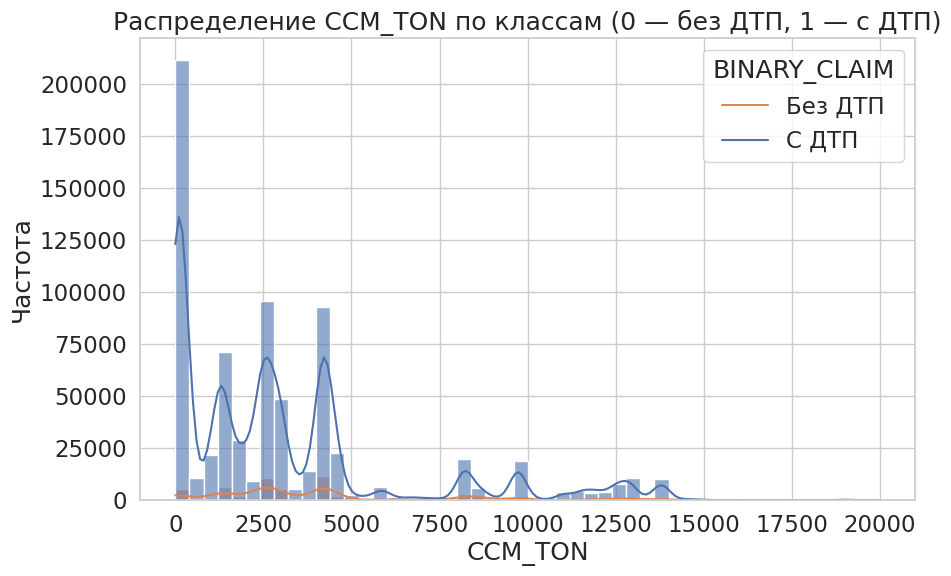

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Убедись, что TARGET_NAME и CCM_TON числовые
data[TARGET_NAME] = data[TARGET_NAME].astype(int)
data['CCM_TON'] = pd.to_numeric(data['CCM_TON'], errors='coerce')

# Удалим NaN в CCM_TON
data_clean = data.dropna(subset=['CCM_TON'])

# Построим гистограммы или KDE
plt.figure(figsize=(10, 6))
sns.histplot(data=data_clean, x='CCM_TON', hue=TARGET_NAME, kde=True, bins=50, alpha=0.6)
plt.title('Распределение CCM_TON по классам (0 — без ДТП, 1 — с ДТП)')
plt.xlabel('CCM_TON')
plt.ylabel('Частота')
plt.legend(title=TARGET_NAME, labels=['Без ДТП', 'С ДТП'])
plt.show()

In [22]:
print("Статистики для CCM_TON:")
display(data_clean.groupby(TARGET_NAME)['CCM_TON'].describe())

Статистики для CCM_TON:


,count,mean,std,min,25%,50%,75%,max
BINARY_CLAIM,,,,,,,,
0,741924.0,3092.719956,3434.880147,0.0,200.0,2480.0,4164.0,20000.0
1,60104.0,4159.948990,3422.845778,0.0,1998.0,2986.0,4461.0,19980.0


In [23]:
from scipy.stats import pointbiserialr

# Точечная бисериальная корреляция (рекомендуется для бинарного + непрерывного)
corr, p_value = pointbiserialr(data_clean[TARGET_NAME], data_clean['CCM_TON'])
print(f"Точечная бисериальная корреляция: {corr:.4f}, p-value: {p_value:.4e}")

# Или просто Пирсон (даст тот же результат по модулю)
pearson_corr = data_clean[['CCM_TON', TARGET_NAME]].corr().iloc[0, 1]
print(f"Корреляция Пирсона: {pearson_corr:.4f}")

Точечная бисериальная корреляция: 0.0816, p-value: 0.0000e+00
Корреляция Пирсона: 0.0816


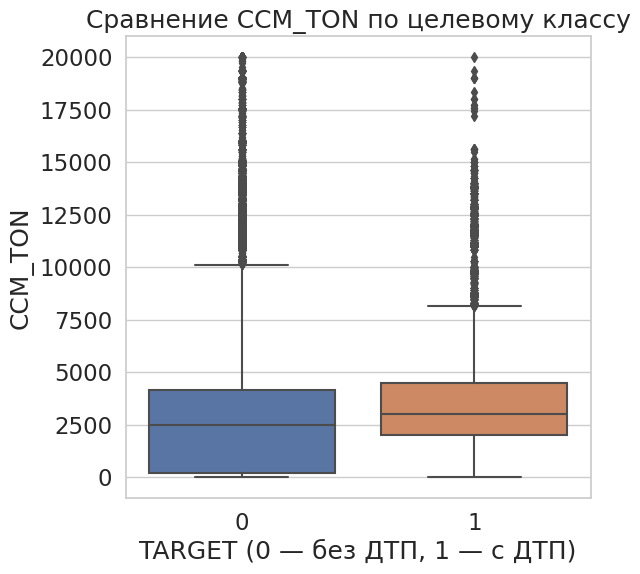

In [24]:
plt.figure(figsize=(6, 6))
sns.boxplot(data=data_clean, x=TARGET_NAME, y='CCM_TON')
plt.title('Сравнение CCM_TON по целевому классу')
plt.xlabel('TARGET (0 — без ДТП, 1 — с ДТП)')
plt.ylabel('CCM_TON')
plt.show()

In [25]:
data

,SEX,INSR_BEGIN,INSR_END,EFFECTIVE_YR,INSR_TYPE,INSURED_VALUE,PREMIUM,OBJECT_ID,PROD_YEAR,SEATS_NUM,CARRYING_CAPACITY,TYPE_VEHICLE,CCM_TON,MAKE,USAGE,CLAIM_PAID,BINARY_CLAIM
0,0,2013-08-08,2014-08-07,08,1202,519755.22,7209.140,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
1,0,2012-08-08,2013-08-07,08,1202,519755.22,7203.890,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
2,0,2011-08-08,2012-08-07,08,1202,519755.22,7045.804,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
3,0,2011-07-08,2011-08-07,08,1202,519755.22,287.250,5000029885,2007.0,4.0,6.0,Pick-up,3153.0,NISSAN,Own Goods,0.00,0
4,0,2013-08-08,2014-08-07,08,1202,285451.24,4286.900,5000029901,2010.0,4.0,7.0,Pick-up,2494.0,TOYOTA,Own Goods,19894.43,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
508494,0,2018-02-02,2019-02-01,12,1202,0.00,294.510,5001350484,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,0.00,0
508495,0,2018-02-02,2019-02-01,12,1202,0.00,299.510,5001350489,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,0.00,0
508496,0,2018-02-02,2019-02-01,12,1202,0.00,294.510,5001350498,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,0.00,0
508497,0,2018-02-02,2019-02-01,12,1202,0.00,294.510,5001350502,2018.0,4.0,7.0,Pick-up,2400.0,TOYOTA,Own Goods,0.00,0
